In [1]:
import argparse
import os
import copy
import sys
import time
from datetime import datetime
import torch
import random
import numpy as np
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from common.utils import HDF5Dataset, GraphCreator
from experiments.models_gnn import MP_PDE_Solver
from experiments.models_cnn import BaseCNN
from experiments.train_helper import *
from equations.PDEs import *


In [2]:
device = torch.device('cuda:0')

In [3]:

def check_directory() -> None:
    """
    Check if log directory exists within experiments
    """
    if not os.path.exists(f'experiments/log'):
        os.mkdir(f'experiments/log')
    if not os.path.exists(f'models'):
        os.mkdir(f'models')
        
check_directory()

In [4]:
pde = CE(device=device)

In [5]:
train_string = f'data/{pde}_train_E1.h5'

In [162]:
super_resolution = [250, 200]
base_resolution = [250, 100]
batch_size = 1
neighbors = 5
time_window = 25
lr_decay = 0.4
unrolling = 1
gunrolling = unrolling
num_epochs = 20
lr = 1e-4

In [163]:
train_dataset = HDF5Dataset(train_string, pde=pde, mode='train', base_resolution=base_resolution, super_resolution=super_resolution)

In [164]:
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4)

In [165]:

    pde.tmin = train_dataset.tmin
    pde.tmax = train_dataset.tmax
    pde.grid_size = base_resolution
    pde.dt = train_dataset.dt

In [166]:

    graph_creator = GraphCreator(pde=pde,
                                 neighbors=neighbors,
                                 time_window=time_window,
                                 t_resolution=base_resolution[0],
                                 x_resolution=base_resolution[1]).to(device)

In [167]:

eq_variables = {}
    
model = MP_PDE_Solver(pde=pde,
                              time_window=graph_creator.tw,
                              eq_variables=eq_variables).to(device)

In [168]:

    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print(f'Number of parameters: {params}')

Number of parameters: 634745


In [169]:

    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[unrolling, 5, 10, 15], gamma=lr_decay)


In [170]:
    # Training loop
    min_val_loss = 10e30
    test_loss = 10e30
    criterion = torch.nn.MSELoss(reduction="sum")

In [171]:
import os
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset
from torch import nn
from torch.nn import functional as F
from typing import Tuple
from torch_geometric.data import Data
from torch_cluster import radius_graph, knn_graph
from equations.PDEs import *

class GraphCreator(nn.Module):
    def __init__(self,
                 pde: PDE,
                 neighbors: int = 2,
                 time_window: int = 5,
                 t_resolution: int = 250,
                 x_resolution: int =100
                 ) -> None:
        """
        Initialize GraphCreator class
        Args:
            pde (PDE): PDE at hand [CE, WE, ...]
            neighbors (int): how many neighbors the graph has in each direction
            time_window (int): how many time steps are used for PDE prediction
            time_ration (int): temporal ratio between base and super resolution
            space_ration (int): spatial ratio between base and super resolution
        Returns:
            None
        """
        super().__init__()
        self.pde = pde
        self.n = neighbors
        self.tw = time_window
        self.t_res = t_resolution
        self.x_res = x_resolution

        assert isinstance(self.n, int)
        assert isinstance(self.tw, int)

    def create_data(self, datapoints: torch.Tensor, steps: list) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Getting data for PDE training at different time points
        Args:
            datapoints (torch.Tensor): trajectory
            steps (list): list of different starting points for each batch entry
        Returns:
            Tuple[torch.Tensor, torch.Tensor]: input data and label
        """
        data = torch.Tensor()
        labels = torch.Tensor()
#         print('datapoints', datapoints.shape)
#         print('steps', steps)
        for (dp, step) in zip(datapoints, steps):
#             print('dp', dp.shape)
#             print('step', step)
            d = dp[step - self.tw:step]
            l = dp[step:self.tw + step]
            data = torch.cat((data, d[None, :]), 0)
            labels = torch.cat((labels, l[None, :]), 0)

        return data, labels


    def create_graph(self,
                     data: torch.Tensor,
                     labels: torch.Tensor,
                     x: torch.Tensor,
                     variables: dict,
                     steps: list) -> Data:
        """
        Getting graph structure out of data sample
        previous timesteps are combined in one node
        Args:
            data (torch.Tensor): input data tensor
            labels (torch.Tensor): label tensor
            x (torch.Tensor): spatial coordinates tensor
            variables (dict): dictionary of equation specific parameters
            steps (list): list of different starting points for each batch entry
        Returns:
            Data: Pytorch Geometric data graph
        """
        nt = self.pde.grid_size[0]
        nx = self.pde.grid_size[1]
        t = torch.linspace(self.pde.tmin, self.pde.tmax, nt)

        u, x_pos, t_pos, y, batch = torch.Tensor(), torch.Tensor(), torch.Tensor(), torch.Tensor(), torch.Tensor()
        for b, (data_batch, labels_batch, step) in enumerate(zip(data, labels, steps)):
            u = torch.cat((u, torch.transpose(torch.cat([d[None, :] for d in data_batch]), 0, 1)), )
            y = torch.cat((y, torch.transpose(torch.cat([l[None, :] for l in labels_batch]), 0, 1)), )
            x_pos = torch.cat((x_pos, x[0]), )
            t_pos = torch.cat((t_pos, torch.ones(nx) * t[step]), )
            batch = torch.cat((batch, torch.ones(nx) * b), )

        # Calculate the edge_index
        if f'{self.pde}' == 'CE':
            dx = x[0][1] - x[0][0]
            radius = self.n * dx + 0.0001
            edge_index = radius_graph(x_pos, r=radius, batch=batch.long(), loop=False)
        elif f'{self.pde}' == 'WE':
            edge_index = knn_graph(x_pos, k=self.n, batch=batch.long(), loop=False)

        graph = Data(x=u, edge_index=edge_index)
        graph.y = y
        graph.pos = torch.cat((t_pos[:, None], x_pos[:, None]), 1)
        graph.batch = batch.long()

        # Equation specific parameters
        if f'{self.pde}' == 'CE':
            alpha, beta, gamma = torch.Tensor(), torch.Tensor(), torch.Tensor()
            for i in batch.long():
                alpha = torch.cat((alpha, torch.tensor([variables['alpha'][i]])[:, None]), )
                beta = torch.cat((beta, torch.tensor([variables['beta'][i]*(-1.)])[:, None]), )
                gamma = torch.cat((gamma, torch.tensor([variables['gamma'][i]])[:, None]), )

            graph.alpha = alpha
            graph.beta = beta
            graph.gamma = gamma

        elif f'{self.pde}' == 'WE':
            bc_left, bc_right, c = torch.Tensor(), torch.Tensor(), torch.Tensor()
            for i in batch.long():
                bc_left = torch.cat((bc_left, torch.tensor([variables['bc_left'][i]])[:, None]), )
                bc_right = torch.cat((bc_right, torch.tensor([variables['bc_right'][i]])[:, None]), )
                c = torch.cat((c, torch.tensor([variables['c'][i]])[:, None]), )

            graph.bc_left = bc_left
            graph.bc_right = bc_right
            graph.c = c

        return graph


    def create_next_graph(self,
                             graph: Data,
                             pred: torch.Tensor,
                             labels: torch.Tensor,
                             steps: list) -> Data:
        """
        Getting new graph for the next timestep
        Method is used for unrolling and when applying the pushforward trick during training
        Args:
            graph (Data): Pytorch geometric data object
            pred (torch.Tensor): prediction of previous timestep ->  input to next timestep
            labels (torch.Tensor): labels of previous timestep
            steps (list): list of different starting points for each batch entry
        Returns:
            Data: Pytorch Geometric data graph
        """
        # Output is the new input
        graph.x = torch.cat((graph.x, pred), 1)[:, self.tw:]
        nt = self.pde.grid_size[0]
        nx = self.pde.grid_size[1]
        t = torch.linspace(self.pde.tmin, self.pde.tmax, nt)
        # Update labels and input timesteps
        y, t_pos = torch.Tensor(), torch.Tensor()
        for (labels_batch, step) in zip(labels, steps):
            y = torch.cat((y, torch.transpose(torch.cat([l[None, :] for l in labels_batch]), 0, 1)), )
            t_pos = torch.cat((t_pos, torch.ones(nx) * t[step]), )
        graph.y = y
        graph.pos[:, 0] = t_pos

        return graph

In [172]:
def training_loop(model: torch.nn.Module,
                  unrolling: list,
                  batch_size: int,
                  optimizer: torch.optim,
                  loader: DataLoader,
                  graph_creator: GraphCreator,
                  criterion: torch.nn.modules.loss,
                  device: torch.cuda.device="cpu") -> torch.Tensor:
    """
    One training epoch with random starting points for every trajectory
    Args:
        model (torch.nn.Module): neural network PDE solver
        unrolling (list): list of different unrolling steps for each batch entry
        batch_size (int): batch size
        optimizer (torch.optim): optimizer used for training
        loader (DataLoader): training dataloader
        graph_creator (GraphCreator): helper object to handle graph data
        criterion (torch.nn.modules.loss): criterion for training
        device (torch.cuda.device): device (cpu/gpu)
    Returns:
        torch.Tensor: training losses
    """

    losses = []
    for (u_base, u_super, x, variables) in loader:
#         print('u_base', u_base.shape)
#         print('u_super', u_super.shape)
#         print('x', x.shape)
#         print('variables', variables)
        optimizer.zero_grad()
        # Randomly choose number of unrollings
        unrolled_graphs = random.choice(unrolling)
#         print('unrolled_graphs', unrolled_graphs)
        steps = [t for t in range(graph_creator.tw,
                                  graph_creator.t_res - graph_creator.tw - (graph_creator.tw * unrolled_graphs) + 1)]
        # Randomly choose starting (time) point at the PDE solution manifold
        random_steps = random.choices(steps, k=batch_size)
#         print('random_steps', random_steps)
        data, labels = graph_creator.create_data(u_super, random_steps)
#         print('data', data.shape)
#         print('labels', labels.shape)
#         if f'{model}' == 'GNN':
        graph = graph_creator.create_graph(data, labels, x, variables, random_steps).to(device)
#         else:
#             data, labels = data.to(device), labels.to(device)
#         print('graph', graph)
        # Unrolling of the equation which serves as input at the current step
        # This is the pushforward trick!!!
        with torch.no_grad():
            for _ in range(unrolled_graphs):
                random_steps = [rs + graph_creator.tw for rs in random_steps]
                _, labels = graph_creator.create_data(u_super, random_steps)
#                 if f'{model}' == 'GNN':
                pred = model(graph)
                graph = graph_creator.create_next_graph(graph, pred, labels, random_steps).to(device)
#                 else:
#                     data = model(data)
#                     labels = labels.to(device)

#         print('graph', graph)
#         return graph
#         if f'{model}' == 'GNN':
        pred = model(graph)
        loss = criterion(pred, graph.y)
#         else:
#             pred = model(data)
#             loss = criterion(pred, labels)

        loss = torch.sqrt(loss)
        loss.backward()
        losses.append(loss.detach() / batch_size)
        optimizer.step()

    losses = torch.stack(losses)
    return losses

In [173]:
def train(args: argparse,
          pde: PDE,
          epoch: int,
          model: torch.nn.Module,
          optimizer: torch.optim,
          loader: DataLoader,
          graph_creator: GraphCreator,
          criterion: torch.nn.modules.loss,
          device: torch.cuda.device="cpu") -> None:
    """
    Training loop.
    Loop is over the mini-batches and for every batch we pick a random timestep.
    This is done for the number of timesteps in our training sample, which covers a whole episode.
    Args:
        args (argparse): command line inputs
        pde (PDE): PDE at hand [CE, WE, ...]
        model (torch.nn.Module): neural network PDE solver
        optimizer (torch.optim): optimizer used for training
        loader (DataLoader): training dataloader
        graph_creator (GraphCreator): helper object to handle graph data
        criterion (torch.nn.modules.loss): criterion for training
        device (torch.cuda.device): device (cpu/gpu)
    Returns:
        None
    """
    print(f'Starting epoch {epoch}...')
    model.train()

    # Sample number of unrolling steps during training (pushforward trick)
    # Default is to unroll zero steps in the first epoch and then increase the max amount of unrolling steps per additional epoch.
    max_unrolling = epoch if epoch <= gunrolling else gunrolling
    unrolling = [r for r in range(max_unrolling + 1)]

    # Loop over every epoch as often as the number of timesteps in one trajectory.
    # Since the starting point is randomly drawn, this in expectation has every possible starting point/sample combination of the training data.
    # Therefore in expectation the whole available training information is covered.
    for i in range(graph_creator.t_res):
        losses = training_loop(model, unrolling, batch_size, optimizer, loader, graph_creator, criterion, device)
        if(i % 1 == 0):
            print(f'Training Loss (progress: {i / graph_creator.t_res:.2f}): {torch.mean(losses)}')
    return losses


In [137]:
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}")
        graph = train(None, pde, epoch, model, optimizer, train_loader, graph_creator, criterion, device=device)
        break

Epoch 0
Starting epoch 0...


KeyboardInterrupt: 

In [174]:
max_unrolling = epoch if epoch <= gunrolling else gunrolling
unrolling = [r for r in range(max_unrolling + 1)]
for (u_base, u_super, x, variables) in train_loader:
#         print('u_base', u_base.shape)
#         print('u_super', u_super.shape)
#         print('x', x.shape)
#         print('variables', variables)
    optimizer.zero_grad()
    # Randomly choose number of unrollings
    unrolled_graphs = random.choice(unrolling)
#         print('unrolled_graphs', unrolled_graphs)
    steps = [t for t in range(graph_creator.tw,
                              graph_creator.t_res - graph_creator.tw - (graph_creator.tw * unrolled_graphs) + 1)]
    # Randomly choose starting (time) point at the PDE solution manifold
    random_steps = random.choices(steps, k=batch_size)
#         print('random_steps', random_steps)
    data, labels = graph_creator.create_data(u_super, random_steps)
#         print('data', data.shape)
#         print('labels', labels.shape)
#         if f'{model}' == 'GNN':
    graph = graph_creator.create_graph(data, labels, x, variables, random_steps).to(device)
    break

In [175]:
u = graph.x # temporal bundling
[j,i] = graph.edge_index

pos_x = graph.pos[:,1] / pde.L
pos_t = graph.pos[:,0] / pde.tmax

# if f'{self.pde}' == 'CE':
dx = graph.pos[1,1] - graph.pos[0,1]
radius = graph_creator.n * dx + 0.0001

print(pos_x)
print(pos_t)
print(radius)

tensor([0.0000, 0.0101, 0.0202, 0.0303, 0.0404, 0.0505, 0.0606, 0.0707, 0.0808,
        0.0909, 0.1010, 0.1111, 0.1212, 0.1313, 0.1414, 0.1515, 0.1616, 0.1717,
        0.1818, 0.1919, 0.2020, 0.2121, 0.2222, 0.2323, 0.2424, 0.2525, 0.2626,
        0.2727, 0.2828, 0.2929, 0.3030, 0.3131, 0.3232, 0.3333, 0.3434, 0.3535,
        0.3636, 0.3737, 0.3838, 0.3939, 0.4040, 0.4141, 0.4242, 0.4343, 0.4444,
        0.4545, 0.4646, 0.4747, 0.4848, 0.4949, 0.5051, 0.5152, 0.5253, 0.5354,
        0.5455, 0.5556, 0.5657, 0.5758, 0.5859, 0.5960, 0.6061, 0.6162, 0.6263,
        0.6364, 0.6465, 0.6566, 0.6667, 0.6768, 0.6869, 0.6970, 0.7071, 0.7172,
        0.7273, 0.7374, 0.7475, 0.7576, 0.7677, 0.7778, 0.7879, 0.7980, 0.8081,
        0.8182, 0.8283, 0.8384, 0.8485, 0.8586, 0.8687, 0.8788, 0.8889, 0.8990,
        0.9091, 0.9192, 0.9293, 0.9394, 0.9495, 0.9596, 0.9697, 0.9798, 0.9899,
        1.0000], device='cuda:0')
tensor([0.6386, 0.6386, 0.6386, 0.6386, 0.6386, 0.6386, 0.6386, 0.6386, 0.6386,
      

In [176]:
# graph.pos.shape
# graph.pos

In [177]:
graph.x.shape

torch.Size([100, 25])

In [178]:
import argparse
import os
import copy
import sys
import time
from datetime import datetime
import torch
import random
import numpy as np
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from common.utils import HDF5Dataset, GraphCreator
from experiments.models_gnn import MP_PDE_Solver
from experiments.models_cnn import BaseCNN
# from experiments.train_helper import *
# from equations.PDEs import *
sys.path.append(os.path.dirname(os.path.expanduser('~/dev/pytorchSPH2/Cconv')))
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.typing import Adj, OptPairTensor, OptTensor, Size
from torch_geometric.utils.repeat import repeat
import torch
from torch import Tensor, nn
from torch.nn import Parameter

from Cconv.cutlass import cutlass

import math
import numpy as np
from typing import Any
from typing import List, Tuple, Union
from torch_sparse import SparseTensor

def uniform(size: int, value: Any):
    if isinstance(value, Tensor):
        bound = 1.0 / math.sqrt(size)
        value.data.uniform_(-bound, bound)
    else:
        for v in value.parameters() if hasattr(value, 'parameters') else []:
            uniform(size, v)
        for v in value.buffers() if hasattr(value, 'buffers') else []:
            uniform(size, v)
     
def constant(value: Any, fill_value: float):
    if isinstance(value, Tensor):
        value.data.fill_(fill_value)
    else:
        for v in value.parameters() if hasattr(value, 'parameters') else []:
            constant(v, fill_value)
        for v in value.buffers() if hasattr(value, 'buffers') else []:
            constant(v, fill_value)
def zeros(value: Any):
    constant(value, 0.)
    
basestring = (str, bytes)
def is_list_of_strings(lst):
        if lst and isinstance(lst, list):
            return all(isinstance(elem, basestring) for elem in lst)
        else:
            return False
from Cconv.cutlass import *
import scipy.optimize

In [179]:
import torch_geometric.nn.aggr

In [180]:

def mapToSpherical(positions):
    x = positions[:,0]
    y = positions[:,1]
    z = positions[:,2]
    r = torch.sqrt(x**2 + y**2 + z**2)
    theta = torch.atan2(y, x)
    phi = torch.acos(z / (r + 1e-7))
    
    return torch.vstack((r,theta,phi)).mT


def ballToCylinder(positions):
    r = torch.linalg.norm(positions, dim = 1)
    xy = torch.linalg.norm(positions[:,:2], dim = 1)
    absz = torch.abs(positions[:,2])

#     debugPrint(r)
#     debugPrint(xy)
#     debugPrint(absz)

    x = positions[:,0]
    y = positions[:,1]
    z = positions[:,2]

    termA = torch.zeros_like(positions)

    eps = 1e-7

    xB = x * r / (xy + eps)
    yB = y * r / (xy + eps)
    zB = 3 / 2 * z
    termB = torch.vstack((xB, yB, zB)).mT

    xC = x * torch.sqrt(3 * r / (r + absz + eps))
    yC = y * torch.sqrt(3 * r / (r + absz + eps))
    zC = torch.sign(z) * r
    termC = torch.vstack((xC, yC, zC)).mT

    mapped = torch.zeros_like(positions)

    maskA = r < eps
    maskB = torch.logical_and(torch.logical_not(maskA), 5/4 * z**2 <= x**2 + y**2)
    maskC = torch.logical_and(torch.logical_not(maskA), torch.logical_not(maskB))

    mapped[maskB] = termB[maskB]
    mapped[maskC] = termC[maskC]

#     debugPrint(mapped)
    return mapped
# debugPrint(cylinderPositions)

def cylinderToCube(positions):
    x = positions[:,0]
    y = positions[:,1]
    z = positions[:,2]
    xy = torch.linalg.norm(positions[:,:2], dim = 1)
    eps = 1e-7

    termA = torch.vstack((torch.zeros_like(x), torch.zeros_like(y), z)).mT
    # debugPrint(termA)

    xB = torch.sign(x) * xy
    yB = 4. / np.pi * torch.sign(x) * xy * torch.atan(y/(x+eps))
    zB = z
    termB = torch.vstack((xB, yB, zB)).mT

    xC = 4. / np.pi * torch.sign(y) * xy * torch.atan(x / (y + eps))
    yC = torch.sign(y) * xy
    zC = z
    termC = torch.vstack((xC, yC, zC)).mT

    maskA = torch.logical_and(torch.abs(x) < eps, torch.abs(y) < eps)
    maskB = torch.logical_and(torch.logical_not(maskA), torch.abs(y) <= torch.abs(x))
    maskC = torch.logical_and(torch.logical_not(maskA), torch.logical_not(maskB))

    # debugPrint(torch.sum(maskA))
    # debugPrint(torch.sum(maskB))
    # debugPrint(torch.sum(maskC))


    mapped = torch.zeros_like(positions)
    mapped[maskA] = termA[maskA]
    mapped[maskB] = termB[maskB]
    mapped[maskC] = termC[maskC]
    
    return mapped

def mapToSpherePreserving(positions):
    cylinderPositions = ballToCylinder(positions)
    cubePositions = cylinderToCube(cylinderPositions)
    return cubePositions

class RbfConv(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        dim: int,
        size: Union[int, List[int]] = 3,
        coordinateMapping : str = 'cartesian',
        rbf : Union[int, List[int]] = 'chebyshev',
        aggr: str = 'sum',

        linearLayer: bool = False,
        feedThrough: bool = False,
        # biasOffset: bool = False,

        preActivation = None,
        postActivation = None,

        bias = True,

        # initializer = torch.nn.init.xavier_uniform_,

        initializer = torch.nn.init.uniform_,

        
        batch_size = [16,16],
        windowFn = None,
        normalizeWeights = True,
        normalizationFactor = None,
        **kwargs
    ):
        super().__init__(aggr=aggr, **kwargs)        
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.dim = dim
        self.coordinateMapping = coordinateMapping
        # print('coordinate mapping', self.coordinateMapping)
        self.size = size if isinstance(size, list) else repeat(size, dim)
        self.rbfs = rbf if is_list_of_strings(rbf) else [rbf] * dim
        self.periodic = [False, False] if coordinateMapping != 'polar' else [False,True]
        self.initializer = initializer
        self.batchSize = batch_size
        self.feedThrough = feedThrough
        self.preActivation = None if preActivation is None else getattr(nn.functional, preActivation)
        self.postActivation = None if postActivation is None else getattr(nn.functional, postActivation)
        self.windowFn = windowFn
        self.use_bias = bias
        # print('Creating layer %d -> %d features'%( in_channels, out_channels))
        # print('For dimensionality: %d'% dim)
        # print('Parameters:')
        # print('\tRBF: ', self.rbfs)
        # print('\tSize: ', self.size)
        # print('\tPeriodic: ', self.periodic)

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)

        if self.use_bias:
            self.bias = Parameter(torch.zeros(out_channels))
        else:
            self.register_parameter('bias', None)

        self.K = torch.tensor(self.size).prod().item()
        if dim == 1:
            self.weight = Parameter(torch.Tensor(self.size[0], in_channels[0], out_channels))
        if dim == 2:
            self.weight = Parameter(torch.Tensor(self.size[0],self.size[1], in_channels[0], out_channels))
        if dim == 3:
            self.weight = Parameter(torch.Tensor(self.size[0],self.size[1], self.size[2], in_channels[0], out_channels))
        initializer(self.weight, -0.05, 0.05)
        with torch.no_grad():
            if self.rbfs[0] in ['chebyshev', 'fourier', 'gabor']:
                for i in range(self.dim):
                    if len(self.rbfs) == 1:
                        self.weight[i] *= np.exp(-i)
                    if len(self.rbfs) == 2:
                        self.weight[i,:] *= np.exp(-i)
                    if len(self.rbfs) == 3:
                        self.weight[i,:,:] *= np.exp(-i)
            if len(self.rbfs) > 1 and self.rbfs[1] in ['chebyshev', 'fourier', 'gabor']:
                for i in range(self.dim):
                    if len(self.rbfs) == 2:
                        self.weight[:,i] *= np.exp(-i)
                    if len(self.rbfs) == 3:
                        self.weight[:,i,:] *= np.exp(-i)
            if len(self.rbfs) > 2 and self.rbfs[2] in ['chebyshev', 'fourier', 'gabor']:
                for i in range(self.dim):
                    self.weight[:,:,i] = self.weight[:,:,i] * np.exp(-i)
            if normalizeWeights:
                if len(self.rbfs) == 2:
                    print('Starting normalization')
                    for i in range(in_channels[0]):
                        for j in range(out_channels):
                            newWeights, _, _, init, final = optimizeWeights2D(weights = self.weight[:,:,i,j].detach(),\
                                                                            basis = self.rbfs, periodicity = self.periodic, \
                                                                            nmc = 32*1024, targetIntegral = 1/in_channels[0], \
                                                                            windowFn = self.windowFn, verbose = False) 
                            self.weight[:,:,i,j] = newWeights
                            print('Normalizing [%2d x %2d]: %1.4e => %1.4e (target: %1.4e)' %(i,j, init, final, 1/in_channels[0]))

                            # self.weight[:,:,i,j] /= in_channels[0]
                    print('Done with normalization\n------------------------------------------')

        self.root_weight = linearLayer
        if linearLayer:
            self.lin = Linear(in_channels[1], out_channels, bias=self.use_bias,
                              weight_initializer= 'uniform')

        # if biasOffset:
        #     self.bias = Parameter(torch.Tensor(out_channels))
        # else:
        #     self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        # if not isinstance(self.weight, nn.UninitializedParameter):
            # size = self.weight.size(0) * self.weight.size(1)
            # self.initializer(self.weight)
        if self.root_weight:
            self.lin.reset_parameters()
        zeros(self.bias)


    def forward(self, x: Union[Tensor, OptPairTensor], edge_index: Adj,
                edge_attr: OptTensor = None, size: Size = None) -> Tensor:
        # print('x', x[0].shape, x)
        # print('edge_index', edge_index.shape, edge_index)
        # print('edge_attr', edge_attr.shape, edge_attr)
        # print('Size', Size)
        # if args.cutlad:
            # out = self.propagate(edge_index, x=x, edge_attr=edge_attr, size=size)
        # else:
        out = self.propagate2(edge_index, x=x, edge_attr=edge_attr, size=size)
        

#         print('out: ', out.shape, out)

        x_r = x[1]
        if self.preActivation is not None:
            out = self.preActivation(out)

        if x_r is not None and self.root_weight:
            out = out + self.lin(x_r) if self.preActivation is not None else self.preActivation(self.lin(x_r))
        if self.bias is not None:
            out = out + self.bias
        if self.feedThrough:
            out = out + x_r if self.preActivation is not None else self.preActivation(x_r)
        if self.postActivation is not None:
            out = self.postActivation(out)
        return out


    def message(self, x_j: Tensor, edge_attr: Tensor) -> Tensor:
        if self.dim == 1:
            u = evalBasisFunction(self.size[0], edge_attr[:,0], which=self.rbfs[0], periodic = self.periodic[0]).T
             
            return torch.einsum('nu, uio,ni -> no',u,self.weight, x_j)
        if self.dim == 2:
            u = evalBasisFunction(self.size[0], edge_attr[:,0], which=self.rbfs[0], periodic = self.periodic[0]).T
            v = evalBasisFunction(self.size[1], edge_attr[:,1], which=self.rbfs[1], periodic = self.periodic[1]).T
            
            return torch.einsum('nu, nv, uvio,ni -> no',u,v,self.weight, x_j)
        if self.dim == 3:
            u = evalBasisFunction(self.size[0], edge_attr[:,0], which=self.rbfs[0], periodic = self.periodic[0]).T
            v = evalBasisFunction(self.size[1], edge_attr[:,1], which=self.rbfs[1], periodic = self.periodic[1]).T
            w = evalBasisFunction(self.size[2], edge_attr[:,1], which=self.rbfs[1], periodic = self.periodic[2]).T
            
            return torch.einsum('nu, nv, uvio,ni -> no',u,v,w,self.weight, x_j)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, dim={self.dim})')
    
    
    def propagate2(self, edge_index: Adj, size: Size = None, **kwargs):
        decomposed_layers = 1 if self.explain else self.decomposed_layers

        for hook in self._propagate_forward_pre_hooks.values():
            res = hook(self, (edge_index, size, kwargs))
            if res is not None:
                edge_index, size, kwargs = res

        size = self.__check_input__(edge_index, size)

        if decomposed_layers > 1:
            user_args = self.__user_args__
            decomp_args = {a[:-2] for a in user_args if a[-2:] == '_j'}
            decomp_kwargs = {
                a: kwargs[a].chunk(decomposed_layers, -1)
                for a in decomp_args
            }
            decomp_out = []

        for i in range(decomposed_layers):
            if decomposed_layers > 1:
                for arg in decomp_args:
                    kwargs[arg] = decomp_kwargs[arg][i]

            coll_dict = self.__collect__(self.__user_args__, edge_index,
                                            size, kwargs)

            msg_kwargs = self.inspector.distribute('message', coll_dict)
            for hook in self._message_forward_pre_hooks.values():
                res = hook(self, (msg_kwargs, ))
                if res is not None:
                    msg_kwargs = res[0] if isinstance(res, tuple) else res
                    
            aggr_kwargs = self.inspector.distribute('aggregate', coll_dict)
            
            convolution = cutlass.apply
            
            inFeatures = kwargs['x'][0]
            
            edge_weights = None
            if not(self.windowFn is None):
                edge_weights = self.windowFn(torch.linalg.norm(kwargs['edge_attr'], axis = 1))
                # print(torch.linalg.norm(kwargs['edge_attr'], axis = 1))
                # print(edge_weights.shape)
                # print(edge_weights)
                # print(inFeatures.shape)
                # inFeatures = inFeatures * window[:,None]
                # print(inFeatures.shape)


            positions = torch.hstack((kwargs['edge_attr'], torch.zeros(kwargs['edge_attr'].shape[0],1, device = kwargs['edge_attr'].device, dtype = kwargs['edge_attr'].dtype)))
            if self.coordinateMapping == 'polar':
                spherical = mapToSpherical(positions)
                mapped = torch.vstack((spherical[:,0] * 2. - 1.,spherical[:,1] / np.pi)).mT
            if self.coordinateMapping == 'cartesian':
                mapped = kwargs['edge_attr']
            if self.coordinateMapping == 'preserving':
                cubePositions = mapToSpherePreserving(positions)
                mapped = torch.vstack((cubePositions[:,0],cubePositions[:,1] / np.pi)).mT


            out = convolution(edge_index, kwargs['x'][0], kwargs['x'][1], mapped, edge_weights, self.weight, 
                                            size[0], self.node_dim,
                                        self.size , self.rbfs, self.periodic, 
                                        self.batchSize[0],self.batchSize[1])

            for hook in self._aggregate_forward_hooks.values():
                res = hook(self, (aggr_kwargs, ), out)
                if res is not None:
                    out = res

            update_kwargs = self.inspector.distribute('update', coll_dict)
            out = self.update(out, **update_kwargs)

            if decomposed_layers > 1:
                decomp_out.append(out)

            if decomposed_layers > 1:
                out = torch.cat(decomp_out, dim=-1)

        for hook in self._propagate_forward_hooks.values():
            res = hook(self, (edge_index, size, kwargs), out)
            if res is not None:
                out = res

        return out
  

In [181]:

#         self,
#         in_channels: int,
#         out_channels: int,
#         dim: int,
#         size: Union[int, List[int]] = 3,
#         coordinateMapping : str = 'cartesian',
#         rbf : Union[int, List[int]] = 'chebyshev',
#         aggr: str = 'sum',

#         linearLayer: bool = False,
#         feedThrough: bool = False,
#         # biasOffset: bool = False,

#         preActivation = None,
#         postActivation = None,

#         bias = True,

#         # initializer = torch.nn.init.xavier_uniform_,

#         initializer = torch.nn.init.uniform_,

        
#         batch_size = [16,16],
#         windowFn = None,
#         normalizeWeights = True,
#         normalizationFactor = None,
#         **kwargs
#     ):
        
layer = RbfConv(in_channels = graph.x.shape[1], out_channels = graph.x.shape[1], dim = 1, size = [4], coordinatemapping = 'cartesian', rbf = ['linear'], feedThrough = False, normalizeWeights = False)
layer = layer.to(device)

In [182]:
u = graph.x # temporal bundling
[j,i] = graph.edge_index

pos_x = graph.pos[:,1][:,None] / pde.L
pos_t = graph.pos[:,0][:,None] / pde.tmax

# if f'{self.pde}' == 'CE':
dx = graph.pos[1,1] - graph.pos[0,1]
radius = graph_creator.n * dx + 0.0001

# print(pos_x)
# print(pos_t)
# print(radius)


# Encode equation specific parameters
# alpha, beta, gamma are used in E1,E2,E3 experiments
# bc_left, bc_right, c are used in WE1, WE2, WE3 experiments
variables = pos_t    # time is treated as equation variable
if "alpha" in eq_variables.keys():
    variables = torch.cat((variables, data.alpha / eq_variables["alpha"]), -1)
if "beta" in eq_variables.keys():
    variables = torch.cat((variables, data.beta / eq_variables["beta"]), -1)
if "gamma" in eq_variables.keys():
    variables = torch.cat((variables, data.gamma / eq_variables["gamma"]), -1)
if "bc_left" in eq_variables.keys():
    variables = torch.cat((variables, data.bc_left), -1)
if "bc_right" in eq_variables.keys():
    variables = torch.cat((variables, data.bc_right), -1)
if "c" in eq_variables.keys():
    variables = torch.cat((variables, data.c / eq_variables["c"]), -1)

# Encoder and processor (message passing)
node_input = torch.cat((u, pos_x, variables), -1)

In [183]:

print(node_input.shape)

torch.Size([100, 27])


In [184]:
layer = RbfConv(in_channels = node_input.shape[1], out_channels = graph.x.shape[1], dim = 1, size = [4], coordinatemapping = 'cartesian', rbf = ['linear'], feedThrough = False, normalizeWeights = False)
layer = layer.to(device)

In [185]:

class RbfNet(torch.nn.Module):
    def __init__(self, fluidFeatures, layers = [16,32,32,25], denseLayer = True, activation = 'swish',
                coordinateMapping = 'cartesian', n = 8, m = 8, windowFn = lambda r: torch.clamp((1 - r)**3, min = 0), rbf_x = 'rbf cubic_spline', rbf_y = 'linear', batchSize = 32, ignoreCenter = False):
        super().__init__()
        self.centerIgnore = ignoreCenter
#         debugPrint(layers)
        
        self.features = copy.copy(layers)
#         debugPrint(fluidFeatures)
#         debugPrint(boundaryFeatures)
        self.convs = torch.nn.ModuleList()
        self.fcs = torch.nn.ModuleList()
#         self.relu = getattr(nn.functional, 'relu')
        self.relu = Swish()
#         debugPrint(fluidFeatures)

        self.convs.append(RbfConv(
            in_channels = fluidFeatures, out_channels = self.features[0],
            dim = 1, size = [n],
            rbf = [rbf_x],
            bias = True,
            linearLayer = False, biasOffset = False, feedThrough = False,
            preActivation = None, postActivation = None,
            coordinateMapping = coordinateMapping,
            batch_size = [batchSize, batchSize], windowFn = windowFn, normalizeWeights = False))
                
        self.fcs.append(nn.Linear(in_features=fluidFeatures,out_features= layers[0],bias=True))
        torch.nn.init.xavier_uniform_(self.fcs[-1].weight)
        torch.nn.init.zeros_(self.fcs[-1].bias)

        self.features[0] = self.features[0]
#         self.fcs.append(nn.Linear(in_features=96,out_features= 2,bias=False))
        
        for i, l in enumerate(layers[1:-1]):
#             debugPrint(layers[i])
#             debugPrint(layers[i+1])
            self.convs.append(RbfConv(
                in_channels = (2 * self.features[0]) if i == 0 else self.features[i], out_channels = layers[i+1],
                dim = 1, size = [n],
                rbf = [rbf_x],
                bias = True,
                linearLayer = False, biasOffset = False, feedThrough = False,
                preActivation = None, postActivation = None,
                coordinateMapping = coordinateMapping,
                batch_size = [batchSize, batchSize], windowFn = windowFn, normalizeWeights = False))
            print(self.convs[-1].weight.shape)
            self.fcs.append(nn.Linear(in_features=2 * layers[0] if i == 0 else layers[i],out_features=layers[i+1],bias=True))
            torch.nn.init.xavier_uniform_(self.fcs[-1].weight)
            torch.nn.init.zeros_(self.fcs[-1].bias)
            
        self.convs.append(RbfConv(
            in_channels = 2 * self.features[-2] if len(layers) == 2 else self.features[-2], out_channels = self.features[-1],
                dim = 1, size = [n],
                rbf = [rbf_x],
                bias = True,
                linearLayer = False, biasOffset = False, feedThrough = False,
                preActivation = None, postActivation = None,
                coordinateMapping = coordinateMapping,
                batch_size = [batchSize, batchSize], windowFn = windowFn, normalizeWeights = False))
        print(self.convs[-1].weight.shape)
        self.fcs.append(nn.Linear(in_features=2 * self.features[-2] if len(layers) == 2 else self.features[-2],out_features=self.features[-1],bias=True))
        torch.nn.init.xavier_uniform_(self.fcs[-1].weight)
        torch.nn.init.zeros_(self.fcs[-1].bias)


    def forward(self, graph):
        u = graph.x # temporal bundling
        [j,i] = graph.edge_index

        pos_x = graph.pos[:,1][:,None] / pde.L
        pos_t = graph.pos[:,0][:,None] / pde.tmax

        # if f'{self.pde}' == 'CE':
        dx = graph.pos[1,1] - graph.pos[0,1]
        radius = graph_creator.n * dx + 0.0001

        # print(pos_x)
        # print(pos_t)
        # print(radius)


        # Encode equation specific parameters
        # alpha, beta, gamma are used in E1,E2,E3 experiments
        # bc_left, bc_right, c are used in WE1, WE2, WE3 experiments
        variables = pos_t    # time is treated as equation variable
        if "alpha" in eq_variables.keys():
            variables = torch.cat((variables, data.alpha / eq_variables["alpha"]), -1)
        if "beta" in eq_variables.keys():
            variables = torch.cat((variables, data.beta / eq_variables["beta"]), -1)
        if "gamma" in eq_variables.keys():
            variables = torch.cat((variables, data.gamma / eq_variables["gamma"]), -1)
        if "bc_left" in eq_variables.keys():
            variables = torch.cat((variables, data.bc_left), -1)
        if "bc_right" in eq_variables.keys():
            variables = torch.cat((variables, data.bc_right), -1)
        if "c" in eq_variables.keys():
            variables = torch.cat((variables, data.c / eq_variables["c"]), -1)

        # Encoder and processor (message passing)
        node_input = torch.cat((u, pos_x, variables), -1)
        
        fj, fi = graph.edge_index
#         fi, fj = radius(fluidPositions, fluidPositions, attributes['support'], max_num_neighbors = 256, batch_x = fluidBatches, batch_y = fluidBatches)
#         bf, bb = radius(boundaryPositions, fluidPositions, attributes['support'], max_num_neighbors = 256, batch_x = boundaryBatches, batch_y = fluidBatches)
        if self.centerIgnore:
            nequals = fi != fj

        i, ni = torch.unique(fi, return_counts = True)
#         b, nb = torch.unique(bf, return_counts = True)
        
        self.ni = ni
        
        if self.centerIgnore:
            fluidEdgeIndex = torch.stack([fi[nequals], fj[nequals]], dim = 0)
        else:
            fluidEdgeIndex = torch.stack([fi, fj], dim = 0)
            
        edge_attr = torch.abs(graph.pos[:,1][fi,None] - graph.pos[:,1][fj,None]) / radius
        
        linearOutput = (self.fcs[0](node_input))
        fluidConvolution = (self.convs[0]((node_input, node_input), fluidEdgeIndex, edge_attr))/ model.ni[:,None]
        ans = torch.hstack((linearOutput, fluidConvolution))
        
        layers = len(self.convs)
        for i in range(1,layers):            
            ansc = self.relu(ans)
            
            ansConv = self.convs[i]((ansc, ansc), fluidEdgeIndex, edge_attr)/ model.ni[:,None]
            ansDense = self.fcs[i](ansc)
            
            
            if self.features[i-1] == self.features[i] and ans.shape == ansConv.shape:
                ans = ansConv + ansDense + ans
            else:
                ans = ansConv + ansDense
        ans = ans *128
        # Decoder (formula 10 in the paper)
        dt = (torch.ones(1, time_window) * pde.dt).to(ans.device)
        dt = torch.cumsum(dt, dim=1)
        # [batch*n_nodes, hidden_dim] -> 1DCNN([batch*n_nodes, 1, hidden_dim]) -> [batch*n_nodes, time_window]
#         diff = self.output_mlp(h[:, None]).squeeze(1)
        out = u[:, -1].repeat(time_window, 1).transpose(0, 1) + dt * ans
        self.pred = dt * ans
        return out
#         return ans 
            

In [186]:
class Swish(nn.Module):
    """
    Swish activation function
    """
    def __init__(self, beta=1):
        super(Swish, self).__init__()
        self.beta = beta

    def forward(self, x):
        return x * torch.sigmoid(self.beta*x)


In [196]:
model = RbfNet(node_input.shape[1], layers = [32,64,64,64,graph_creator.tw], n = 5).to(device)

torch.Size([5, 64, 64])
torch.Size([5, 64, 64])
torch.Size([5, 64, 64])
torch.Size([5, 64, 25])


In [197]:
out = model(graph)

In [198]:
print(out[:,0],model.pred[:,0])

tensor([-0.9501, -0.9511, -0.9424, -0.9345, -0.9265, -0.9179, -0.9091, -0.8994,
        -0.8887, -0.8770, -0.8641, -0.8499, -0.8344, -0.8173, -0.7986, -0.7781,
        -0.7557, -0.7312, -0.7045, -0.6754, -0.6438, -0.6096, -0.5727, -0.5329,
        -0.4903, -0.4447, -0.3963, -0.3451, -0.2913, -0.2350, -0.1765, -0.1161,
        -0.0541,  0.0091,  0.0730,  0.1372,  0.2011,  0.2643,  0.3262,  0.3863,
         0.4440,  0.4988,  0.5499,  0.5970,  0.6391,  0.6757,  0.7058,  0.7285,
         0.7428,  0.7474,  0.7409,  0.7220,  0.6899,  0.6455,  0.5922,  0.5367,
         0.4869,  0.4495,  0.4275,  0.4209,  0.4281,  0.4472,  0.4766,  0.5147,
         0.5605,  0.6129,  0.6711,  0.7344,  0.8020,  0.8734,  0.9478,  1.0245,
         1.1030,  1.1825,  1.2624,  1.3420,  1.4207,  1.4978,  1.5727,  1.6449,
         1.7137,  1.7785,  1.8389,  1.8943,  1.9440,  1.9874,  2.0240,  2.0528,
         2.0730,  2.0835,  2.0826,  2.0681,  2.0369,  1.9833,  1.8717,  0.4754,
        -0.4682, -0.6491, -0.6472, -0.63

In [199]:
model.ni

tensor([ 5,  6,  7,  8,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10,  9,  8,  7,  6,  5], device='cuda:0')

In [200]:

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
# if args.gpus == 1:
print('Number of parameters', count_parameters(model))

Number of parameters 89010


In [201]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    graph = train(None, pde, epoch, model, optimizer, train_loader, graph_creator, criterion, device=device)
#     break

Epoch 0
Starting epoch 0...
Training Loss (progress: 0.00): 369.3271918022525
Training Loss (progress: 0.00): 372.1511740631602
Training Loss (progress: 0.01): 370.06298980904097
Training Loss (progress: 0.01): 376.55414185229745
Training Loss (progress: 0.02): 369.6056717566664
Training Loss (progress: 0.02): 373.4927130134343
Training Loss (progress: 0.02): 368.4060757579558
Training Loss (progress: 0.03): 372.583835125801
Training Loss (progress: 0.03): 368.4837123310689
Training Loss (progress: 0.04): 373.7582952059707
Training Loss (progress: 0.04): 369.18375203082024
Training Loss (progress: 0.04): 371.2929840179496
Training Loss (progress: 0.05): 372.0606143982953
Training Loss (progress: 0.05): 374.4827088308447
Training Loss (progress: 0.06): 372.5157736996741
Training Loss (progress: 0.06): 372.3049434910257
Training Loss (progress: 0.06): 367.75823786399394
Training Loss (progress: 0.07): 372.58322382032173
Training Loss (progress: 0.07): 372.1171680247706
Training Loss (pro

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faa68911ee0>
Traceback (most recent call last):
  File "/home/winchenbach/anaconda3/envs/mp-pde-solvers/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/winchenbach/anaconda3/envs/mp-pde-solvers/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/winchenbach/anaconda3/envs/mp-pde-solvers/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faa68911ee0>
Traceback (most recent call last):
  File "/home/winchenbach/anaconda3/envs/mp-pde-solvers/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
 

Training Loss (progress: 0.53): 368.68058177462035
Training Loss (progress: 0.53): 374.59979314466796
Training Loss (progress: 0.54): 368.24803438231254
Training Loss (progress: 0.54): 372.2598834240581
Training Loss (progress: 0.54): 374.31486558056474
Training Loss (progress: 0.55): 371.41900170365284
Training Loss (progress: 0.55): 370.46738761015274
Training Loss (progress: 0.56): 377.0240878468454
Training Loss (progress: 0.56): 371.31054839670054
Training Loss (progress: 0.56): 371.44261919801056
Training Loss (progress: 0.57): 368.36798222899506
Training Loss (progress: 0.57): 371.7241449632072
Training Loss (progress: 0.58): 372.0577206789879
Training Loss (progress: 0.58): 371.25281957082984
Training Loss (progress: 0.58): 369.3176612204575
Training Loss (progress: 0.59): 370.2655992579779
Training Loss (progress: 0.59): 374.39608064716526
Training Loss (progress: 0.60): 373.63751129364863
Training Loss (progress: 0.60): 371.56905647268434
Training Loss (progress: 0.60): 371.9

Training Loss (progress: 0.18): 2641.8308046392503
Training Loss (progress: 0.18): 2702.148241514721
Training Loss (progress: 0.18): 2786.5622838954414
Training Loss (progress: 0.19): 2656.4912553016693
Training Loss (progress: 0.19): 2742.53056644561
Training Loss (progress: 0.20): 2728.758415419257
Training Loss (progress: 0.20): 2781.702719047784
Training Loss (progress: 0.20): 2674.7869405111333
Training Loss (progress: 0.21): 2736.7251815739446
Training Loss (progress: 0.21): 2740.303278651182
Training Loss (progress: 0.22): 2633.982348332632
Training Loss (progress: 0.22): 2802.646951971347
Training Loss (progress: 0.22): 2660.20648588684
Training Loss (progress: 0.23): 2704.5862652296705
Training Loss (progress: 0.23): 2794.684076204062
Training Loss (progress: 0.24): 2775.2810590612976
Training Loss (progress: 0.24): 2732.111797620627
Training Loss (progress: 0.24): 2781.2127467751598
Training Loss (progress: 0.25): 2592.173477072377
Training Loss (progress: 0.25): 2670.4323273

Training Loss (progress: 0.83): 2712.874114098874
Training Loss (progress: 0.83): 2699.714272395369
Training Loss (progress: 0.84): 2634.17814343437
Training Loss (progress: 0.84): 2724.784671630347
Training Loss (progress: 0.84): 2717.226867308625
Training Loss (progress: 0.85): 2700.5754022886113
Training Loss (progress: 0.85): 2746.5032260801554
Training Loss (progress: 0.86): 2577.037895178746
Training Loss (progress: 0.86): 2792.7457298123354
Training Loss (progress: 0.86): 2686.19077325396
Training Loss (progress: 0.87): 2620.9993577796367
Training Loss (progress: 0.87): 2655.881140775948
Training Loss (progress: 0.88): 2761.282712355211
Training Loss (progress: 0.88): 2644.340732283449
Training Loss (progress: 0.88): 2676.8234889260875
Training Loss (progress: 0.89): 2792.394521280976
Training Loss (progress: 0.89): 2695.1632334035985
Training Loss (progress: 0.90): 2717.0307564377995
Training Loss (progress: 0.90): 2575.438033050326
Training Loss (progress: 0.90): 2761.38218471

Training Loss (progress: 0.48): 2844.3492724671655
Training Loss (progress: 0.48): 2721.835262546428
Training Loss (progress: 0.48): 2807.2628654168498
Training Loss (progress: 0.49): 2819.4610807416775
Training Loss (progress: 0.49): 2759.0804578072984
Training Loss (progress: 0.50): 2768.0036130924323
Training Loss (progress: 0.50): 2718.378021393709
Training Loss (progress: 0.50): 2633.316535005119
Training Loss (progress: 0.51): 2706.1922573730394
Training Loss (progress: 0.51): 2637.293071650304
Training Loss (progress: 0.52): 2709.8137882344954
Training Loss (progress: 0.52): 2755.7908832121802
Training Loss (progress: 0.52): 2756.1850532403428
Training Loss (progress: 0.53): 2725.3214607410664
Training Loss (progress: 0.53): 2709.5847059731723
Training Loss (progress: 0.54): 2742.467572856095
Training Loss (progress: 0.54): 2774.9443390458837
Training Loss (progress: 0.54): 2661.041263846312
Training Loss (progress: 0.55): 2698.617974867001
Training Loss (progress: 0.55): 2709.6

Training Loss (progress: 0.12): 2743.803404239428
Training Loss (progress: 0.13): 2769.8696586028377
Training Loss (progress: 0.13): 2817.2260754528197
Training Loss (progress: 0.14): 2821.9485340988713
Training Loss (progress: 0.14): 2712.57735014359
Training Loss (progress: 0.14): 2706.958717279895
Training Loss (progress: 0.15): 2736.6422503388103
Training Loss (progress: 0.15): 2738.80731295006
Training Loss (progress: 0.16): 2756.0558327926838
Training Loss (progress: 0.16): 2603.559896084563
Training Loss (progress: 0.16): 2698.7027025535535
Training Loss (progress: 0.17): 2701.930546830542
Training Loss (progress: 0.17): 2745.8697945040194
Training Loss (progress: 0.18): 2682.2896376498484
Training Loss (progress: 0.18): 2797.174719045911
Training Loss (progress: 0.18): 2766.4795133145353
Training Loss (progress: 0.19): 2706.91666238923
Training Loss (progress: 0.19): 2667.2508345531423
Training Loss (progress: 0.20): 2672.538895381294
Training Loss (progress: 0.20): 2694.819243

Training Loss (progress: 0.78): 2808.0105610931137
Training Loss (progress: 0.78): 2705.0262529805414
Training Loss (progress: 0.78): 2691.743329137113
Training Loss (progress: 0.79): 2744.276865406151
Training Loss (progress: 0.79): 2700.1761619736517
Training Loss (progress: 0.80): 2594.210292621946
Training Loss (progress: 0.80): 2674.6722684660276
Training Loss (progress: 0.80): 2668.349382661341
Training Loss (progress: 0.81): 2648.402518353885
Training Loss (progress: 0.81): 2703.3037886085294
Training Loss (progress: 0.82): 2783.4308861045492
Training Loss (progress: 0.82): 2685.031423658309
Training Loss (progress: 0.82): 2650.4964336112516
Training Loss (progress: 0.83): 2755.4604145400435
Training Loss (progress: 0.83): 2711.914453595914
Training Loss (progress: 0.84): 2649.632089558758
Training Loss (progress: 0.84): 2647.006882424392
Training Loss (progress: 0.84): 2728.3632132592625
Training Loss (progress: 0.85): 2723.9412319858093
Training Loss (progress: 0.85): 2688.005

KeyboardInterrupt: 

IndexError: too many indices for tensor of dimension 2

In [88]:

for (u_base, u_super, x, variables) in train_loader:
    print(u_base.shape)
    print(u_super.shape)
    steps = [t for t in range(graph_creator.tw,
                          graph_creator.t_res - graph_creator.tw - (graph_creator.tw * unrolled_graphs) + 1)]
# Randomly choose starting (time) point at the PDE solution manifold
    random_steps = random.choices(steps, k=batch_size)
    #         print('random_steps', random_steps)
    data, labels = graph_creator.create_data(u_super, random_steps)
    #         print('data', data.shape)
    #         print('labels', labels.shape)
    #         if f'{model}' == 'GNN':
    graph = graph_creator.create_graph(data, labels, x, variables, random_steps).to(device)
    out = model(graph)
    break

torch.Size([1, 250, 100])
torch.Size([1, 250, 100])


In [89]:
from tqdm.notebook import tqdm

In [90]:
nr_gt_steps = 2
nx_base_resolution = base_resolution[1]
losses = []
losses_base = []

predictions = []
superData = []
for (u_base, u_super, x, variables) in train_loader:
    losses_tmp = []
    losses_base_tmp = []
    with torch.no_grad():
        superData.append(u_super[:,:graph_creator.tw * nr_gt_steps,:])
        predictions.append(u_super[0,:graph_creator.tw * nr_gt_steps,:].transpose(0,1))
        same_steps = [graph_creator.tw * nr_gt_steps] * batch_size
        data, labels = graph_creator.create_data(u_super, same_steps)
#         if f'{model}' == 'GNN':
        graph = graph_creator.create_graph(data, labels, x, variables, same_steps).to(device)
#         predictions.append(graph.x)
        superData.append(labels)
        pred = model(graph)
        predictions.append(pred)
        loss = criterion(pred, graph.y) / nx_base_resolution
#         else:
#             data, labels = data.to(device), labels.to(device)
#             pred = model(data)
#             loss = criterion(pred, labels) / nx_base_resolution

        losses_tmp.append(loss / batch_size)

        # Unroll trajectory and add losses which are obtained for each unrolling
        for step in tqdm(range(graph_creator.tw * (nr_gt_steps + 1), graph_creator.t_res - graph_creator.tw + 1, graph_creator.tw)):
            same_steps = [step] * batch_size
            _, labels = graph_creator.create_data(u_super, same_steps)
            superData.append(labels)
#             if f'{model}' == 'GNN':
            graph = graph_creator.create_next_graph(graph, pred, labels, same_steps).to(device)
            pred = model(graph)
            predictions.append(pred)
            loss = criterion(pred, graph.y) / nx_base_resolution
#             else:
#                 labels = labels.to(device)
#                 pred = model(pred)
#                 loss = criterion(pred, labels) / nx_base_resolution
            losses_tmp.append(loss / batch_size)

        # Losses for numerical baseline
        for step in tqdm(range(graph_creator.tw * nr_gt_steps, graph_creator.t_res - graph_creator.tw + 1,
                          graph_creator.tw)):
            same_steps = [step] * batch_size
            _, labels_super = graph_creator.create_data(u_super, same_steps)
            _, labels_base = graph_creator.create_data(u_base, same_steps)
            loss_base = criterion(labels_super, labels_base) / nx_base_resolution
            losses_base_tmp.append(loss_base / batch_size)

    losses.append(torch.sum(torch.stack(losses_tmp)))
    losses_base.append(torch.sum(torch.stack(losses_base_tmp)))
    break
losses = torch.stack(losses)
losses_base = torch.stack(losses_base)
print(f'Unrolled forward losses {torch.mean(losses)}')
print(f'Unrolled forward base losses {torch.mean(losses_base)}')

  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

Unrolled forward losses 114.51279828521601
Unrolled forward base losses 2.022497083863585


In [91]:
u_super.shape

torch.Size([1, 250, 100])

In [92]:
testData = torch.hstack([p.to(device) for p in predictions])
referenceData = torch.vstack([(p[0,:,:].to(device)) for p in superData])
print(testData.shape)
print(referenceData.shape)
print(referenceData)

torch.Size([100, 250])
torch.Size([250, 100])
tensor([[0.3333, 0.2818, 0.2279,  ..., 0.4468, 0.4045, 0.3579],
        [0.3400, 0.2875, 0.2328,  ..., 0.4558, 0.4128, 0.3655],
        [0.3468, 0.2933, 0.2378,  ..., 0.4649, 0.4213, 0.3730],
        ...,
        [1.9332, 1.9898, 2.0304,  ..., 1.7730, 1.8361, 1.8979],
        [1.9330, 1.9898, 2.0304,  ..., 1.7723, 1.8356, 1.8975],
        [1.9327, 1.9897, 2.0305,  ..., 1.7716, 1.8351, 1.8971]],
       device='cuda:0')


<IPython.core.display.Javascript object>


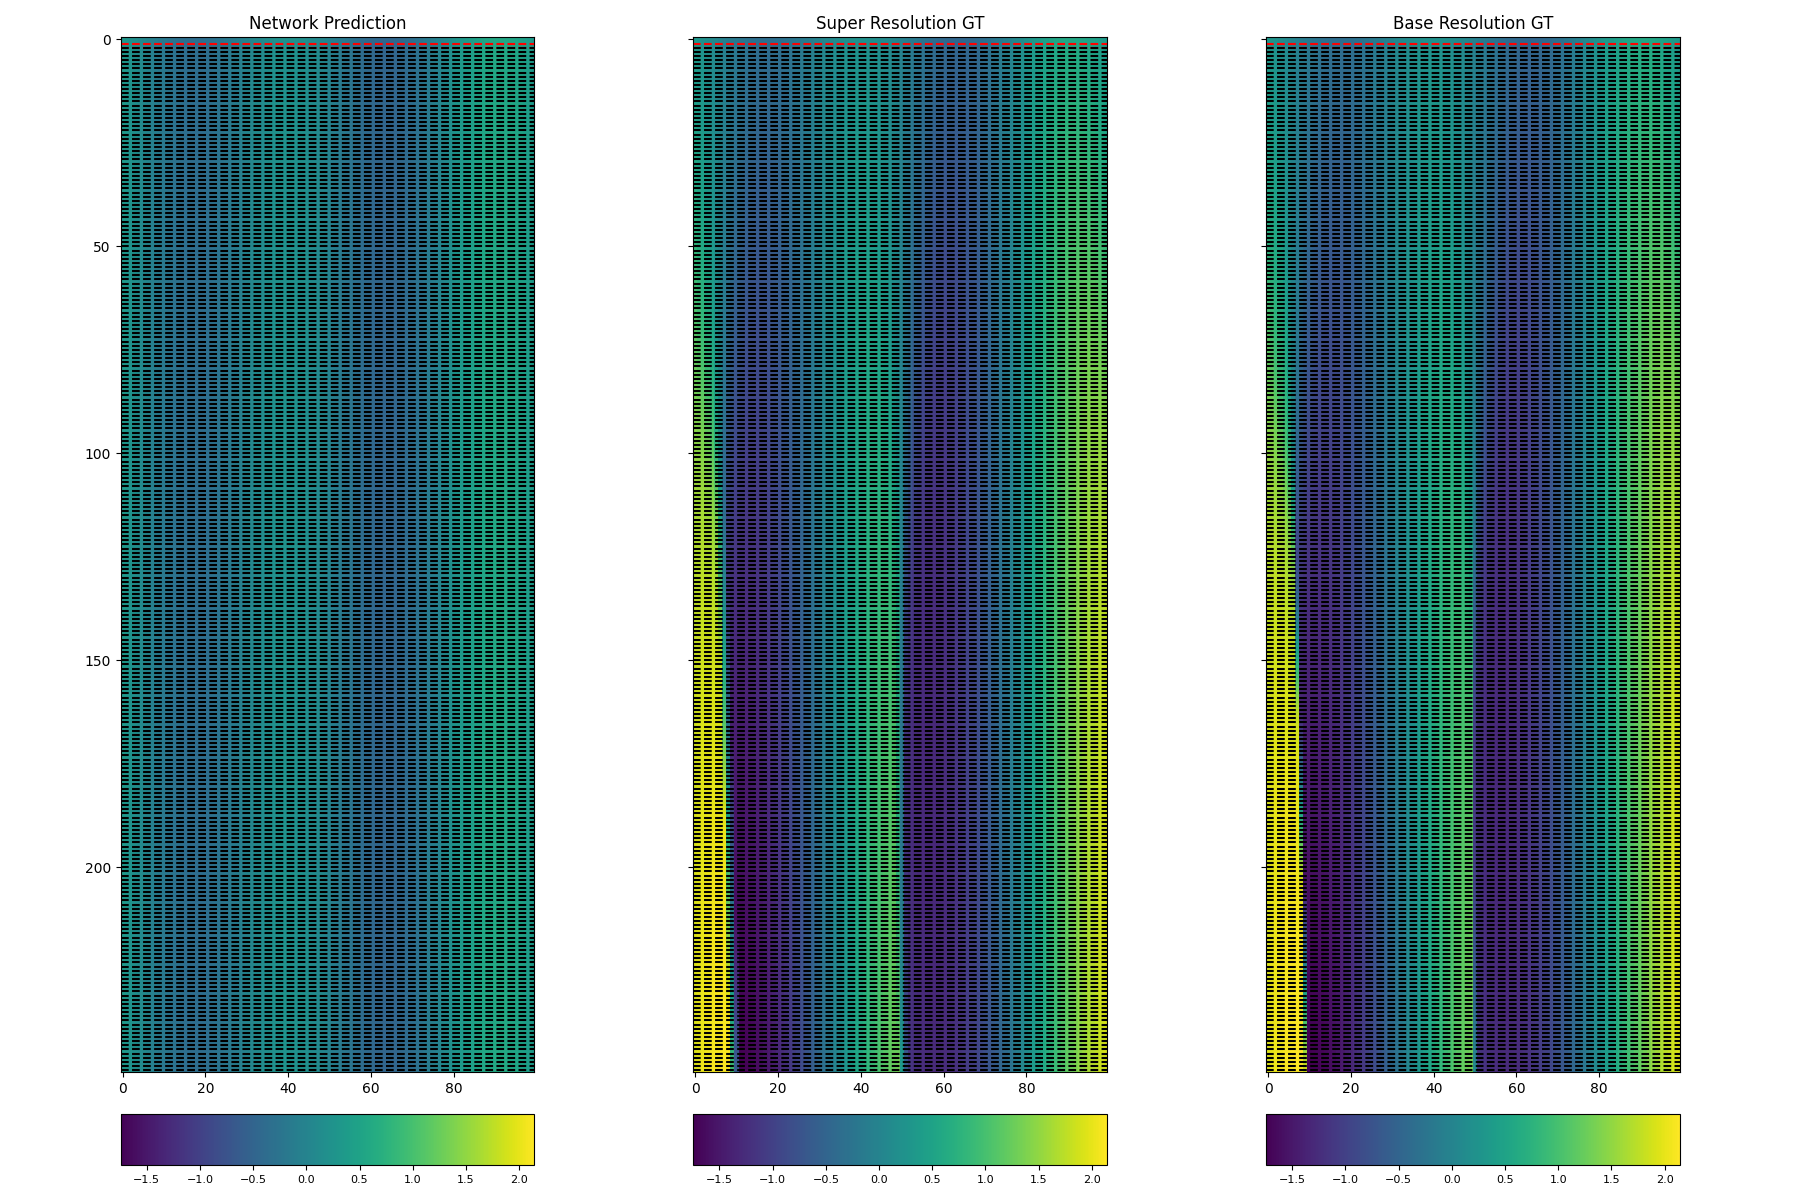

In [93]:
%matplotlib notebook 
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axis = plt.subplots(1, 3, figsize=(18,12), sharex = True, sharey = True, squeeze = False)

for i in range(nr_gt_steps):
    axis[0,0].axhline((i+1) * graph_creator.tw, ls = '--', c = 'red')
    axis[0,1].axhline((i+1) * graph_creator.tw, ls = '--', c = 'red')
    axis[0,2].axhline((i+1) * graph_creator.tw, ls = '--', c = 'red')

for i in range(graph_creator.tw * nr_gt_steps, graph_creator.t_res - graph_creator.tw + 1,
                          graph_creator.tw):
    axis[0,0].axhline(i,ls= '--', c = 'black')
    axis[0,1].axhline(i,ls= '--', c = 'black')
    axis[0,2].axhline(i,ls= '--', c = 'black')

networkOutput = testData.detach().cpu().numpy().transpose()
referenceSolution = referenceData.detach().cpu().numpy()
baseSolution = u_base[0,:,:].detach().cpu().numpy()
    
stacked = np.hstack((networkOutput, referenceSolution, baseSolution))

axis[0,0].set_title('Network Prediction')
im = axis[0,0].imshow(networkOutput, vmin = np.min(stacked), vmax = np.max(stacked))
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("bottom", size="5%", pad="4%")
cbar = fig.colorbar(im, cax=cax1,orientation='horizontal')
cbar.ax.tick_params(labelsize=8) 

axis[0,1].set_title('Super Resolution GT')
im = axis[0,1].imshow(referenceSolution, vmin = np.min(stacked), vmax = np.max(stacked))
ax1_divider = make_axes_locatable(axis[0,1])
cax1 = ax1_divider.append_axes("bottom", size="5%", pad="4%")
cbar = fig.colorbar(im, cax=cax1,orientation='horizontal')
cbar.ax.tick_params(labelsize=8) 

axis[0,2].set_title('Base Resolution GT')
im = axis[0,2].imshow(baseSolution, vmin = np.min(stacked), vmax = np.max(stacked))
ax1_divider = make_axes_locatable(axis[0,2])
cax1 = ax1_divider.append_axes("bottom", size="5%", pad="4%")
cbar = fig.colorbar(im, cax=cax1,orientation='horizontal')
cbar.ax.tick_params(labelsize=8) 

fig.tight_layout()